In [1]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lem = WordNetLemmatizer()
RANDOM_STATE = 50
UNK_ID = 1
PAD_ID = 0
MAX_LEN = 20

2022-05-13 12:09:38.860165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 12:09:38.860188: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaibhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vaibhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vaibhav/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/vaibhav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def format_sequence(s):
    s =  re.sub(r'(?<=[^\s0-9])(?=[.,;?])', r' ', s)
    s = re.sub(r'\((\d+)\)', r'', s)
    s = re.sub(r'\s\s', ' ', s)
    s = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", s)
    s = re.sub(r"\'s", " \'s", s)
    s = re.sub(r"\'ve", " \'ve", s)
    s = re.sub(r"n\'t", " n\'t", s)
    s = re.sub(r"\'re", " \'re", s)
    s = re.sub(r"\'d", " \'d", s)
    s = re.sub(r"\'ll", " \'ll", s)
    s = re.sub(r",", " , ", s)
    s = re.sub(r"!", " ! ", s)
    s = re.sub(r"\"", " \" ", s)
    s = re.sub(r"\(", " ( ", s)
    s = re.sub(r"\)", " ) ", s)
    s = re.sub(r"\?", " ? ", s)
    s = re.sub(r"\s{2,}", " ", s)
    s = re.sub(r"\.", " . ", s)
    s = re.sub(r"., ", " , ", s)
    s = re.sub(r"\\n", " ", s)
    return s.strip().lower()

def make_sequences(arr,lower=True,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'):
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(arr)

    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    features = tokenizer.texts_to_sequences(arr)
    
    print(f'There are {len(features)} sequences.')

    features = np.array(features)

    return word_idx,idx_word,num_words,word_counts,features

def create_train_valid(features,labels,num_words,train_fraction = 0.7,max_valid=1000):

    # features,labels = shuffle(features,labels,random_state = RANDOM_STATE)

    train_end = max(int(train_fraction*len(labels)),len(labels)-max_valid)

    train_features = np.asarray(features[:train_end])
    valid_features = np.asarray(features[train_end:])

    train_labels = np.asarray(labels[:train_end])
    valid_labels = np.asarray(labels[train_end:])
    
    return train_features,valid_features,train_labels,valid_labels

In [4]:
data = pd.read_csv('../datasets/dataset.csv').dropna(axis=0,how='any')
# print(data.columns)
data['text'].str.replace('[^a-zA-Z]', ' ')

text = [format_sequence(a) for a in data['text'].to_list()]
labels = data['label'].to_list()

lower = False
filters = '!"%;[\\]^_`{|}~\t\n'

word_idx,idx_word,num_words,word_counts,features = make_sequences(text,lower,filters)
X_train, X_valid, y_train, y_valid = create_train_valid(features,labels,num_words,train_fraction=1)
training_dict = {'X_train': X_train, 'X_valid': X_valid,'y_train': y_train, 'y_valid': y_valid}



/tmp/ipykernel_30487/2121837504.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'].str.replace('[^a-zA-Z]', ' ')


There are 26709 sequences.


/tmp/ipykernel_30487/302809221.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


In [5]:
glove_loc = '../glove.6B.100d.txt'
glove = np.loadtxt(glove_loc,dtype='str',comments=None)

vectors = glove[:,1:].astype('float')
words = glove[:,0]

del glove

In [6]:
word_lookup = {word:vector for word,vector in zip(words,vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for i,word in enumerate(word_idx.keys()):
    vector = word_lookup.get(word,None)

    if vector is not None:
        embedding_matrix[i+1,:] = vector
    else:
        not_found +=1

embedding_matrix = np.nan_to_num(embedding_matrix)

print(f'{not_found} words not found.')

4421 words not found.


In [8]:
model = Sequential()

model.add(Embedding(input_dim=len(word_idx)+1,output_dim=100,weights=[embedding_matrix],trainable=False))

model.add(Bidirectional(LSTM(64,return_sequences=False,dropout=0.2,recurrent_dropout=0.2)))

# model.add(Bidirectional(LSTM(64,return_sequences=False,dropout=0.3,recurrent_dropout=0.1)))

model.add(Dense(64,activation='relu'))

model.add(Dense(32,activation='relu'))

model.add(Dense(16,activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

x = np.array(training_dict['X_train'])
y = np.array(training_dict['y_train']).astype(np.float32)

# model = load_model('./models/model1')

x =     pad_sequences(x,padding="post")


history = model.fit(x, y, epochs = 25, batch_size = 64, 
        
        verbose = 1)


Epoch 1/25
418/418 [==============================] - 30s 63ms/step - loss: 0.5413 - accuracy: 0.7282
Epoch 2/25
418/418 [==============================] - 26s 63ms/step - loss: 0.4271 - accuracy: 0.8223
Epoch 3/25
418/418 [==============================] - 25s 59ms/step - loss: 0.3847 - accuracy: 0.8435
Epoch 4/25
418/418 [==============================] - 23s 54ms/step - loss: 0.3558 - accuracy: 0.8591
Epoch 5/25
418/418 [==============================] - 24s 57ms/step - loss: 0.3333 - accuracy: 0.8701
Epoch 6/25
418/418 [==============================] - 22s 52ms/step - loss: 0.3164 - accuracy: 0.8730
Epoch 7/25
418/418 [==============================] - 23s 55ms/step - loss: 0.2993 - accuracy: 0.8851
Epoch 8/25
418/418 [==============================] - 28s 67ms/step - loss: 0.2840 - accuracy: 0.8889
Epoch 9/25
418/418 [==============================] - 26s 62ms/step - loss: 0.2718 - accuracy: 0.8936
Epoch 10/25
418/418 [==============================] - 20s 47ms/step - loss: 0.262

In [12]:
model.save('./models/model1')

model.evaluate(x,y,batch_size=64)

2022-05-13 12:36:04.547336: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/model1/assets


418/418 [==============================] - 7s 15ms/step - loss: 0.0647 - accuracy: 0.9797


[0.06473221629858017, 0.9796697497367859]

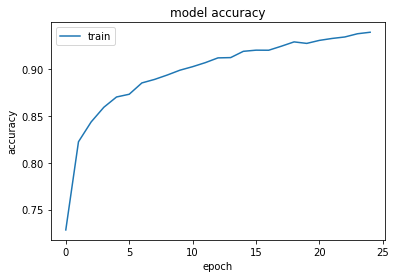

In [10]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

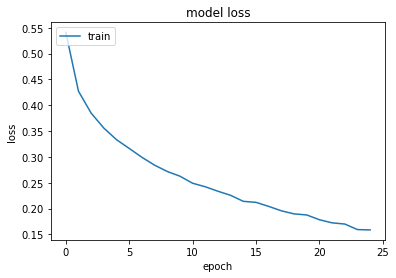

In [11]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from IPython.display import Image
model_name = 'model1'
model_dir = './models/'

plot_model(model, to_file=f'{model_dir}{model_name}.png', show_shapes=True)

Image(f'{model_dir}{model_name}.png')



In [ ]:
str = ['']

tokenizer = Tokenizer(lower=lower, filters=filters)
tokenizer.fit_on_texts(str)

tx = tokenizer.texts_to_sequences(str)
print(tx)
print(model.predict(tx)[0])